# Make a Planet "M"

Numerical Modeling of a hypothetical planet
## “M” planet

radius = 2500 km
density profile:
- 2 g/cm^3 at $r$ = 2500 km
- 6 g/cm^3 at $r$ = 0 km
calculate pressure (in GPa) as a function of depth


Consider to use numerical methods and a programing language

## Calculation of pressure from density profile

We assume that the compression is adiabatic, i.e. That there is no exchange of heat which could cause temperature variations and ad a thermal expansion contribution to the density variations with pressure. We also assume that the Earth is in hydrostatic equilibrium and spherically symmetrical, hence:
$$ 
dP=-\rho g dr 
$$
where $P$ is the pressure at radius $r$ or depth $z$ ($r$[km]=6371-$z$) and $\rho$ and $g$ are the density and acceleration of gravity at radius $r$ respectively, with:

$$
g=Gm/r^2=4\pi G/r^2 \int_0^r \rho r^2 dr
$$
where $m$ is the man of the sphere of radius $r$ and density $\rho$ and $G=6.66\times 10^{-8}$ SI is the gravitational constant. So:
$$
\frac{dP}{dr} = -4\pi G\rho/r^2 \int_0^r \rho r^2 dr.
$$


Text(0, 0.5, 'Pressure (GPa)')

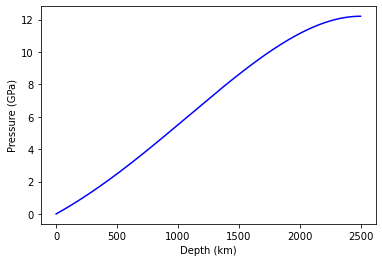

In [13]:
import scipy.integrate
import matplotlib.pyplot as plt
import numpy as np

G = 6.66e-11  # gravitational constant: N (m/kg)^2

class PressureDepth():
    """
    Calculation of pressure from density profile
    """
    def __init__(self):
        self.planet_radius = 2500.0e3 # planet radius
        self.density = np.linspace(6000.0, 2000.0, 25000)  # generate density table
        self.radius = np.linspace(0.0,2500.0e3, 25000)  # generate radius table
        self.g = [] #initialize g
        self.pressure = [] #initialize pressure
        self.depth=[]

    def compute_gravity(self):
        """
        compute gravity from density profile
        """
        density = self.density
        radii = self.radius
        g = scipy.integrate.cumtrapz(G*4.*np.pi*density*radii*radii, x=radii, initial=0.)
        g[1:] = g[1:]/radii[1:]/radii[1:]
        self.g = g[:]
        return g[:]
        
    def compute_pressure(self):
        """
        compute pressure from density profile
        """
        radii = self.radius[::-1]
        density = self.density[::-1]
        gravity = self.compute_gravity()[::-1]
        
        # convert radii to depth
        depth = self.planet_radius - radii
        pressure = scipy.integrate.cumtrapz(gravity*density, x=depth, initial=0.)
        
        self.pressure = pressure
        self.depth = depth
        
p = PressureDepth()
p.planet_radius = 2500.0e3
p.density = np.linspace(6000, 2000, 25000)
p.radius = np.linspace(0.0, p.planet_radius, 25000)
p.compute_pressure()

plt.plot(p.depth/1e3, p.pressure/1e9, 'b-')
plt.xlabel("Depth (km)")
plt.ylabel("Pressure (GPa)")

# Build A Planet

For Earth we have well-constrained one-dimensional density models.  This allows us to
calculate pressure as a funcion of depth.  Furthermore, petrologic data and assumptions
regarding the convective state of the planet allow us to estimate the temperature.
For planets other than Earth we have much less information, and in particular we
know almost nothing about the pressure and temperature in the interior.  Instead, we tend
to have measurements of things like mass, radius, and moment-of-inertia.  We would like
to be able to make a model of the planet's interior that is consistent with those
measurements.
However, there is a difficulty with this.  In order to know the density of the planetary
material, we need to know the pressure and temperature.  In order to know the pressure,
we need to know the gravity profile.  And in order to the the gravity profile, we need
to know the density.  This is a nonlinear problem which requires us to iterate to find
a self-consistent solution.
Here we show an example that does this, using the planet Mercury as motivation.
*Uses:*
* :doc:`mineral_database`
* :class:`burnman.composite.Composite`
* :func:`burnman.material.Material.evaluate`

In [12]:
# import necessary modules

from __future__ import absolute_import
from __future__ import print_function

import os
import sys
# hack to allow scripts to be placed in subdirectories next to burnman:
if not os.path.exists('burnman') and os.path.exists('../burnman'):
    sys.path.insert(1, os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np

import burnman
import burnman.mineral_helpers as helpers

%matplotlib inline

Procedures
--------------------

This example allows the user to define layers of planets of known outer radius and self-
consistently solve for the density, pressure and gravity profiles. The calculation will
iterate until the difference between central pressure calculations are less than 1e-5.
The planet class in BurnMan (../burnman/planet.py) allows users to call multiple
properties of the model planet after calculations, such as the mass of an individual layer,
the total mass of the planet and the moment if inertia. See planets.py for information
on each of the parameters which can be called.
*Uses:*
* :doc:`mineral_database`
* :class:`burnman.planet`

## Define the composition of the planet as individual layers

A layer is defined by 5 parameters: Name, mineral or rock composition, outer radius, temperature profile and number of slices within the layer.

The minerals that make up our core do not currently implement the thermal equation of state, so we will define the temperature as None. For an isothermal profile this can be change to a singular value (e.g. 300)

Planet Zog consists of 4 layers:
The inner core is made of Fe_Dewaele with user-defined temperatures and self-consistent pressures
The outer core is made of Liquid_Fe_Anderson with user-defined temperatures and self-consistent pressures
The lower mantle is made of Mg_Perovskite with adiabatic temperatures and self-consistent pressures
The upper mantle is made of Forsterite with adiabatic temperatures and self-consistent pressures

Iteration 1 maximum relative pressure error: 9.6e-01
Iteration 2 maximum relative pressure error: 4.6e-01
Iteration 3 maximum relative pressure error: 1.8e-01
Iteration 4 maximum relative pressure error: 6.6e-02
Iteration 5 maximum relative pressure error: 2.3e-02
Iteration 6 maximum relative pressure error: 8.3e-03
Iteration 7 maximum relative pressure error: 2.9e-03
Iteration 8 maximum relative pressure error: 1.0e-03
Iteration 9 maximum relative pressure error: 3.6e-04
Iteration 10 maximum relative pressure error: 1.3e-04
Iteration 11 maximum relative pres

/usr/local/anaconda3/lib/python3.8/site-packages/burnman/seismic.py:269: UserWarning: Gravity is not given in PREM and is now being computed. This will only work when density is defined for the entire planet.  Use at your own risk. 
  warnings.warn(


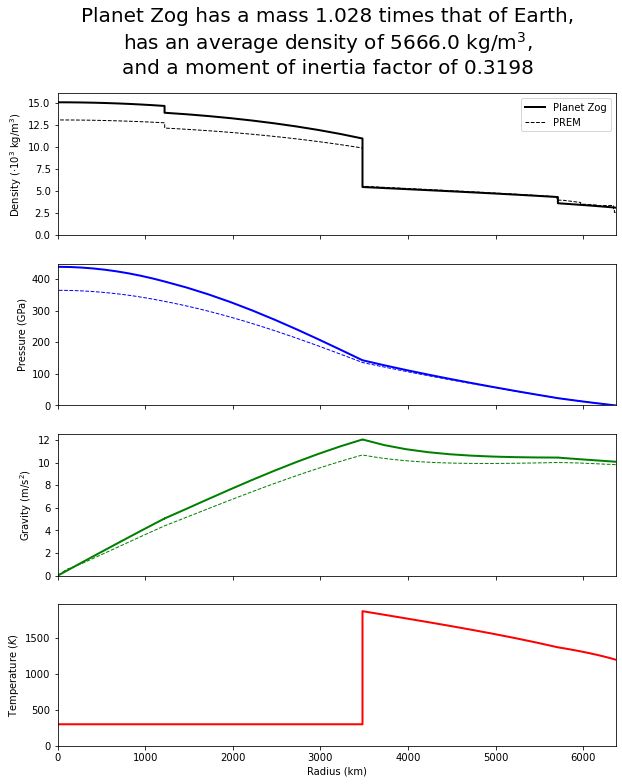

In [12]:
if __name__ == '__main__':
    # FIRST: we must define the composition of the planet as individual layers.
    # A layer is defined by 4 parameters: Name, min_depth, max_depth,and number of slices within the layer.
    # Separately the composition and the temperature_mode need to set.
    radius_planet = 6371.e3
    # inner_core
    inner_core = burnman.Layer('inner core', radii = np.linspace(0,1220.e3,10))
    inner_core.set_material(burnman.minerals.other.Fe_Dewaele())
    
    # The minerals that make up our core do not currently implement the thermal equation of state, so we will set the temperature at 300 K.
    inner_core.set_temperature_mode('user-defined',
        300.*np.ones_like(inner_core.radii))

    # outer_core
    outer_core = burnman.Layer('outer core', radii = np.linspace(1220.e3,3480.e3,10))
    outer_core.set_material(burnman.minerals.other.Liquid_Fe_Anderson())
    # The minerals that make up our core do not currently implement the thermal equation of state, so we will define the temperature at 300 K.
    outer_core.set_temperature_mode('user-defined', 300.*np.ones_like(outer_core.radii))

    # Next the Mantle.
    lower_mantle = burnman.Layer('lower mantle', radii = np.linspace(3480.e3, 5711.e3, 10))
    lower_mantle.set_material(burnman.minerals.SLB_2011.mg_bridgmanite())
    lower_mantle.set_temperature_mode('adiabatic')
    upper_mantle = burnman.Layer('upper mantle', radii = np.linspace(5711.e3, 6371e3, 10))
    upper_mantle.set_material(burnman.minerals.SLB_2011.forsterite())
    upper_mantle.set_temperature_mode('adiabatic', temperature_top = 1200.)



    # Now we calculate the planet.
    planet_zog = burnman.Planet('Planet Zog',
                                [inner_core, outer_core, lower_mantle, upper_mantle],
                                verbose=True)
    print(planet_zog)
    
    # Here we compute its state. Go BurnMan Go!
    # (If we were to change composition of one of the layers, we would have to
    # recompute the state)
    planet_zog.make()
    
    # Now we output the mass of the planet and moment of inertia
    print('\nmass/Earth= {0:.3f}, moment of inertia factor= {1:.4f}'.format(planet_zog.mass / 5.97e24,
                                                                          planet_zog.moment_of_inertia_factor))
    
    # And here's the mass of the individual layers:
    for layer in planet_zog.layers:
        print('{0} mass fraction of planet {1:.3f}'.format(layer.name, layer.mass / planet_zog.mass))
    print('')

    # Let's get PREM to compare everything to as we are trying
    # to imitate Earth
    prem = burnman.seismic.PREM()
    premradii = 6371.e3 - prem.internal_depth_list()
    premdensity, prempressure, premgravity,premvs,premvp = prem.evaluate(
        ['density', 'pressure', 'gravity', 'v_s','v_p'])

    
    # Now let's plot everything up

    # Optional prettier plotting
    # plt.style.use('ggplot')
    
    figure = plt.figure(figsize=(10, 12))
    figure.suptitle(
        '{0} has a mass {1:.3f} times that of Earth,\n'
        'has an average density of {2:.1f} kg/m$^3$,\n'
        'and a moment of inertia factor of {3:.4f}'.format(
            planet_zog.name,
            planet_zog.mass/5.97e24,
            planet_zog.average_density,
            planet_zog.moment_of_inertia_factor),
            fontsize=20)

    ax = [figure.add_subplot(4, 1, i) for i in range(1, 5)]

    ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3, 'k', linewidth=2.,
               label=planet_zog.name)
    ax[0].plot( premradii / 1.e3, premdensity / 1.e3, '--k', linewidth=1.,
        label='PREM')
    ax[0].set_ylim(0., (max(planet_zog.density) / 1.e3) + 1.)
    ax[0].set_ylabel('Density ($\cdot 10^3$ kg/m$^3$)')
    ax[0].legend()

    # Make a subplot showing the calculated pressure profile
    ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9, 'b', linewidth=2.)
    ax[1].plot(premradii / 1.e3, prempressure / 1.e9, '--b', linewidth=1.)
    ax[1].set_ylim(0., (max(planet_zog.pressure) / 1e9) + 10.)
    ax[1].set_ylabel('Pressure (GPa)')

    # Make a subplot showing the calculated gravity profile
    ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity, 'g', linewidth=2.)
    ax[2].plot(premradii / 1.e3, premgravity, '--g', linewidth=1.)
    ax[2].set_ylabel('Gravity (m/s$^2)$')
    ax[2].set_ylim(0., max(planet_zog.gravity) + 0.5)

    # Make a subplot showing the calculated temperature profile
    ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature, 'r', linewidth=2.)
    ax[3].set_ylabel('Temperature ($K$)')
    ax[3].set_xlabel('Radius (km)')
    ax[3].set_ylim(0., max(planet_zog.temperature) + 100)

    for i in range(3):
        ax[i].set_xticklabels([])
    for i in range(4):
        ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)
    
    plt.show()

## You can also make your own mineral

In [11]:
# first define a class for your new mineral
from burnman.mineral import Mineral # import the Mineral class
from burnman.processchemistry import dictionarize_formula, formula_mass

# my liquid iron, changed \gamma from 1.7 to 2.7
class my_liquid_iron(Mineral):
    """
    liquid iron equation of state from Anderson and Ahrens (1994), $\gamma$ was changed from 1.7 to 2.7
    """
    def __init__(self):
        formula='Fe1.0'
        formula = dictionarize_formula(formula)
        m = formula_mass(formula)
        rho_0 = 7019.
        V_0 = m/rho_0
        D = 7766.
        Lambda = 1146.
        self.params = {
            'name': 'liquid iron',
            'formula': formula,
            'equation_of_state': 'aa',
            'P_0': 1.e5,
            'T_0': 1811.,
            'S_0': 100., # to fit
            'molar_mass': m,
            'V_0': V_0,
            'E_0': 0.,
            'K_S': 109.7e9,
            'Kprime_S': 4.661,
            'Kprime_prime_S': -0.043e-9,
            'grueneisen_0': 2.7,
            'grueneisen_prime': -0.130/m*1.e-6,
            'grueneisen_n': -1.870,
            'a': [248.92*m, 289.48*m],
            'b': [0.4057*m, -1.1499*m],
            'Theta': [1747.3, 1.537],
            'theta': 5000.,
            'lmda': [-325.23*m, 302.07*m, 30.45*m],
            'xi_0': 282.67*m,
            'F': [D/rho_0, Lambda/rho_0],
            'n': sum(formula.values()),
            'molar_mass': m}
        Mineral.__init__(self)


## Homework 1

Make your own icy Super Earth.

### Basic parameters for the super Earth:
- Radius = 1.5 x Radius(Earth)
- Ice layer: 0.5 x Radius(Earth)
- Mantle + Core layer: 1 x Radius(Earth)
- Temperature of the ice layer: 300 K
- Temperature of the Mantle: adiabatic as shown in the above example
- Temperature of the core: 300 K

Plot: Density, pressure, gravity, temperature as a function of depth
    

In [1]:
import burnman
print(burnman.__version__)

0.10.0-pre


In [25]:
conda install git

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Today we're making my beer fridge.
Planet GoBows consists of 5 layers:
The inner core is made of Ice_VII with user-defined temperatures and self-consistent pressures
The outer core is made of Liquid_Fe_Anderson with user-defined temperatures and self-consistent pressures
The lower mantle is made of Mg_Perovskite with adiabatic temperatures and self-consistent pressures
The upper mantle is made of Forsterite with adiabatic temperatures and self-consistent pressures
The ice layer is made of Ice_VII with user-defined temperatures and self-consistent pressures

Iteration 1 maximum relative pressure error: 9.4e-01
Iteration 2 maximum relative pressure error: 4.5e-01
Iteration 3 maximum relative pressure error: 1.8e-01
Iteration 4 maximum relative pressure error: 7.0e-02
Iteration 5 maximum relative pressure error: 2.7e-02
Iteration 6 maximum relative pressure error: 1.0e-02
Iteration 7 maximum relative pressure error: 3.9e-03
Iteration 8 maximum relative pressure error: 1.5e-03
Iteration 9 

C:\Users\fdsa4\anaconda3\lib\site-packages\burnman\seismic.py:269: UserWarning: Gravity is not given in PREM and is now being computed. This will only work when density is defined for the entire planet.  Use at your own risk. 
  warnings.warn(


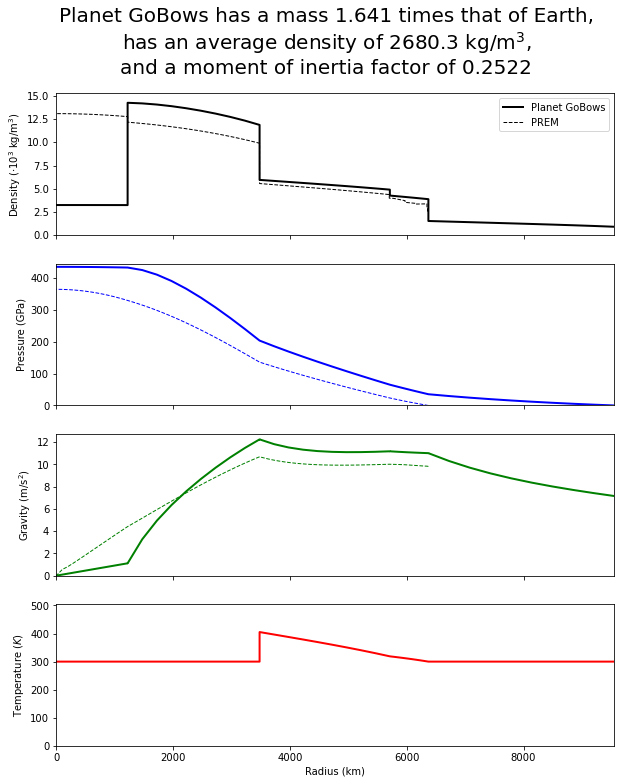

go bows lmao


In [29]:
print ("Today we're making my beer fridge.")
# recall that total r= 1.5x earth, and ice layer = 0.5x earth; therefore the other layers don't change
# we're just adding an extra layer of ice over the existing earth
from __future__ import absolute_import
from __future__ import print_function
#
import os
import sys
# hack to allow scripts to be placed in subdirectories next to burnman:
if not os.path.exists('burnman') and os.path.exists('../burnman'):
    sys.path.insert(1, os.path.abspath('..'))
#
import matplotlib.pyplot as plt
import numpy as np
#
import burnman
import burnman.mineral_helpers as helpers
#
%matplotlib inline

#_____________________________________

#This is where the actual code starts

#The first thing we need to do is to define ice as a mineral; we're using Ice VII

#K_0 and K_0', the bulk modulus and its derivative were taken from Hemley et. al. in Laulima; using the 
#zero-pressure bulk modulus for Ice VII, listed in Fig 2

#For the shear modulus I used a value from here http://people.ee.ethz.ch/~luethim/pdf/script/pdg/appendixB.pdf

#I was not able to find anything regarding shear modulus in Hemley et. al, so I used the values found in the
#textbook excerpt.

#I then used the fact that K = lambda + (2/3)*u to calculate lambda as appx 21 GPa

from burnman.mineral import Mineral # import the Mineral class
from burnman.processchemistry import dictionarize_formula, formula_mass
class Ice(Mineral):
    """
    it's just ice lmao
    """
    def __init__(self):
        formula='H2.0 O1.0'
        formula = dictionarize_formula(formula)
        m = formula_mass(formula)
        rho_0 = 917.
        V_0 = m/rho_0
        D = 917.
        Lambda = 21.
        self.params = {
            'name': 'Ice_VII',
            'formula': formula,
            'equation_of_state': 'bm3',
            'P_0': 1.e5,
            'T_0': 1811.,
            'S_0': 100., # to fit
            'molar_mass': m,
            'V_0': V_0,
            'E_0': 0.,
            'K_0': 23e9,
            'Kprime_0': 4.15,
            'Kprime_prime_0': 0,
            'F': [D/rho_0, Lambda/rho_0],
            'n': sum(formula.values()),
            'molar_mass': m}
        Mineral.__init__(self)
#__________________________

# Now we are constructing Planet GoBows, which is compositionally similar to earth, except that
# its inner core is made out of ice, and it has a sheet of ice that is 0.5 the radius of earth above its mantle.
        
if __name__ == '__main__':
    
    # FIRST: we must define the composition of the planet as individual layers.
    # A layer is defined by 4 parameters: Name, min_depth, max_depth,and number of slices within the layer.
    # Separately the composition and the temperature_mode need to set.
    radius_planet = 6371.e3
    # inner_core
    inner_core = burnman.Layer('inner core', radii = np.linspace(0,1220.e3,10))
    inner_core.set_material(Ice())
    
    # The minerals that make up our core do not currently implement the thermal equation of state, so we will set the temperature at 300 K.
    inner_core.set_temperature_mode('user-defined',
        300.*np.ones_like(inner_core.radii))

    # outer_core
    outer_core = burnman.Layer('outer core', radii = np.linspace(1220.e3,3480.e3,10))
    outer_core.set_material(burnman.minerals.other.Liquid_Fe_Anderson())
    # The minerals that make up our core do not currently implement the thermal equation of state, so we will define the temperature at 300 K.
    outer_core.set_temperature_mode('user-defined', 300.*np.ones_like(outer_core.radii))

    # Next the Mantle.
    lower_mantle = burnman.Layer('lower mantle', radii = np.linspace(3480.e3, 5711.e3, 10))
    lower_mantle.set_material(burnman.minerals.SLB_2011.mg_bridgmanite())
    lower_mantle.set_temperature_mode('adiabatic')
    upper_mantle = burnman.Layer('upper mantle', radii = np.linspace(5711.e3, 6371e3, 10))
    upper_mantle.set_material(burnman.minerals.SLB_2011.forsterite())
    upper_mantle.set_temperature_mode('adiabatic', temperature_top = 1200.)
    
    #ice layer
    ice_layer = burnman.Layer ('ice layer', radii = np.linspace(6371.e3,9556.e3,10))
    ice_layer.set_material(Ice())
    ice_layer.set_temperature_mode('user-defined',
        300.*np.ones_like(ice_layer.radii))



    # Now we calculate the planet.
    planet_zog = burnman.Planet('Planet GoBows',
                                [inner_core, outer_core, lower_mantle, upper_mantle, ice_layer],
                                verbose=True)
    print(planet_zog)
    
    # Here we compute its state. Go BurnMan Go! DON'T FUCK IT UP BURNMAN
    # (If we were to change composition of one of the layers, we would have to
    # recompute the state)
    planet_zog.make()
    
    # Now we output the mass of the planet and moment of inertia
    print('\nmass/Earth= {0:.3f}, moment of inertia factor= {1:.4f}'.format(planet_zog.mass / 5.97e24,
                                                                          planet_zog.moment_of_inertia_factor))
    
    # And here's the mass of the individual layers:
    for layer in planet_zog.layers:
        print('{0} mass fraction of planet {1:.3f}'.format(layer.name, layer.mass / planet_zog.mass))
    print('')

    # Let's get PREM to compare everything to as we are trying
    # to imitate Earth
    prem = burnman.seismic.PREM()
    premradii = 6371.e3 - prem.internal_depth_list()
    premdensity, prempressure, premgravity,premvs,premvp = prem.evaluate(
        ['density', 'pressure', 'gravity', 'v_s','v_p'])

    
    # Now let's plot everything up

    # Optional prettier plotting
    # plt.style.use('ggplot')
    
    figure = plt.figure(figsize=(10, 12))
    figure.suptitle(
        '{0} has a mass {1:.3f} times that of Earth,\n'
        'has an average density of {2:.1f} kg/m$^3$,\n'
        'and a moment of inertia factor of {3:.4f}'.format(
            planet_zog.name,
            planet_zog.mass/5.97e24,
            planet_zog.average_density,
            planet_zog.moment_of_inertia_factor),
            fontsize=20)

    ax = [figure.add_subplot(4, 1, i) for i in range(1, 5)]

    ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3, 'k', linewidth=2.,
               label=planet_zog.name)
    ax[0].plot( premradii / 1.e3, premdensity / 1.e3, '--k', linewidth=1.,
        label='PREM')
    ax[0].set_ylim(0., (max(planet_zog.density) / 1.e3) + 1.)
    ax[0].set_ylabel('Density ($\cdot 10^3$ kg/m$^3$)')
    ax[0].legend()

    # Make a subplot showing the calculated pressure profile
    ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9, 'b', linewidth=2.)
    ax[1].plot(premradii / 1.e3, prempressure / 1.e9, '--b', linewidth=1.)
    ax[1].set_ylim(0., (max(planet_zog.pressure) / 1e9) + 10.)
    ax[1].set_ylabel('Pressure (GPa)')

    # Make a subplot showing the calculated gravity profile
    ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity, 'g', linewidth=2.)
    ax[2].plot(premradii / 1.e3, premgravity, '--g', linewidth=1.)
    ax[2].set_ylabel('Gravity (m/s$^2)$')
    ax[2].set_ylim(0., max(planet_zog.gravity) + 0.5)

    # Make a subplot showing the calculated temperature profile
    ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature, 'r', linewidth=2.)
    ax[3].set_ylabel('Temperature ($K$)')
    ax[3].set_xlabel('Radius (km)')
    ax[3].set_ylim(0., max(planet_zog.temperature) + 100)

    for i in range(3):
        ax[i].set_xticklabels([])
    for i in range(4):
        ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)
    
    plt.show()
    
print ("go bows lmao")

In [24]:
pip install git+https://github.com/geodynamics/burnman

  Cloning https://github.com/geodynamics/burnman to c:\users\fdsa4\appdata\local\temp\pip-req-build-49ibo41b

  Created wheel for burnman: filename=burnman-0.10.0rc0-py3-none-any.whl size=2157614 sha256=166875abe3a0c7b4c57e4057af3c3707198556b3e2b3be3e8f6feec2dcbbee35
  Stored in directory: C:\Users\fdsa4\AppData\Local\Temp\pip-ephem-wheel-cache-tdny29lz\wheels\53\6a\98\f9dca9ea1f8974bb07470c003e2bd908a4106d2fe62e87f561
Successfully built burnman
